<a href="https://colab.research.google.com/github/MeghnaDixit38/BTP/blob/main/2d_coupled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import torch 
import torch.nn as nn
import torch.autograd as ag

In [ ]:
pi = np.pi
from torch.utils.data import Dataset, DataLoader

Solving the PDE: \\
$$-u'(x) = f(x)$$
Given: $$u (x \rightarrow \infty) = 0$$


eq: \\
$$e^{-\lambda} \left(\frac{\nu^{'}}{r} + \frac{1}{r^2} \right) - \frac{1}{r^2} = 0$$
$$e^{-\lambda} \left(\frac{\lambda^{'}}{r} - \frac{1}{r^2} \right) + \frac{1}{r^2} = 0$$

Rewritten as:
$$ \nu^{'} = \frac{e^{\lambda} - 1}{r}  $$
$$ \lambda^{'} = \frac{1-e^{\lambda}}{r}  $$

Substituting $$ f = e^{-\lambda} $$
$$ g = e^{\nu} $$
$$ r = \frac{1}{\rho} $$


In [ ]:
## Exact solution
# def g_exact(xt):
#   g = 1 - np.exp()
#   # g = (1-1/xt)
#   return g

# def f_exact(xt):
#   f = (1-1/xt)
#   return f

## Derivative
def f_dot(f , xt):
  f_d = (1-f)*xt
  # f_d = (1-f)/xt
  return f_d

def g_dot(f, g , xt):
  g_d = g*(1/f -1)*xt
  # g_d = g*(1/f -1)/xt
  return g_d

Exact: 
$$ e^{-\lambda} = e^{\nu} = 1 - \frac{1}{r} $$
$$ f = g = 1-\rho $$

In [ ]:
class data(Dataset):
  def __init__(self, x):
    self.ts = torch.tensor(x, dtype=torch.float32).unsqueeze(1)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    xs = self.x[idx]
    return xs

def tensor(x):
    return torch.tensor(x, dtype=torch.float32)

### DNN Model

In [ ]:
class DNN(nn.Module):
    def __init__(self, dim_in=1, dim_out=2,
                 n_layers=2, n_neurons=10, activation=nn.Tanh()):
        super(DNN, self).__init__()

        self.dim_in = dim_in
        self.dim_out = dim_out
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.activation = activation

        layers = [nn.Linear(dim_in, n_neurons), activation]
        for i in range(n_layers - 2):
            layers.extend([nn.Linear(n_neurons, n_neurons), activation])
        layers.extend([nn.Linear(n_neurons, dim_out)])
        self.layers = nn.Sequential(*layers)

    def forward(self, xt):
        return self.layers(xt)

def _D1(u, x, idx_u=0):
    Du = ag.grad(
        u[:, idx_u], x, torch.ones_like(u[:, idx_u]),
        create_graph=True
    )[0]
    return Du

def _D2(u, x, idx_u=0, idx_x=0):
    Du = ag.grad(
        u[:, idx_u], x, torch.ones_like(u[:, idx_u]),
        create_graph=True
    )[0]
    grad_out = torch.zeros_like(Du)
    grad_out[:, idx_x] = 1.0
    D2u = ag.grad(Du, x, grad_out, create_graph=True)[0]
    return D2u

class PhysicsLoss:
    def __init__(self, model):
        self.model = model

    def __call__(self, xs):
        '''
        This function needs to be implemented for each problem.
        '''
        raise NotImplementedError()

### Residual

In [ ]:
class UnitInterval(Dataset):
    def __init__(self, n_interior=1000, left = 0.0, right = 1.0):
        h = (right-left)/n_interior
        self.n_interior = n_interior
        xs = np.linspace(left + h/5, right - h/5, n_interior)
        self.xs = xs.reshape((n_interior, 1))
        self.xbs_l = np.array([left]).reshape((1, 1))
        self.xbs_r = np.array([right]).reshape((1, 1))

    def __len__(self):
        return self.n_interior

    def __getitem__(self, idx):
        return self.xs[idx]


class Residual_PINN(PhysicsLoss):
    def __init__(self, model, data, fn ,gn, bdy_wt_u =1.0, bdy_wt_v =1.0):
      super().__init__(model)

      self.model = model
      self.data = data
      self.fn = fn
      self.gn = gn
      self.bdy_wt_u = bdy_wt_u
      self.bdy_wt_v = bdy_wt_v

    def _squared_residual(self, x, u , ux, v, vx):
      return (ux - self.fn(u , x))**2 + (vx - self.gn(u, v, x))**2

    def _interior_loss(self, xs):
      u = self.model(xs)[:,0].unsqueeze(1)
      v = self.model(xs)[:,1].unsqueeze(1)
      # print('u=',u, u.size())
      D1u = _D1(u, xs)
      D2u = _D2(u, xs)
      D1v = _D1(v, xs)
      D2v = _D2(v, xs)
      loss_int = torch.mean(self._squared_residual(xs, u , D1u, v, D1v))
      return loss_int


    def _boundary_loss(self, u, xs, bc_u = 1.0, bc_v = 1.0):
      loss_bdy = torch.sum((u-bc_u)**2)
      return loss_bdy

    def __call__(self, xs):
      loss = self._interior_loss(xs)

      if self.bdy_wt_u > 1e-6:
        # For 1st order PDE
        u = self.model(xs)[:,0].unsqueeze(1)
        v = self.model(xs)[:,1].unsqueeze(1)
        loss +=  self.bdy_wt_u*self._boundary_loss(u, tensor(self.data.xbs_l)) + self.bdy_wt_v*self._boundary_loss(v, tensor(self.data.xbs_l))
        # For 2nd order PDE
        # loss +=  self.bdy_wt_r*self._boundary_loss(tensor(self.data.xbs_r)) + self.bdy_wt_l*self._boundary_loss(tensor(self.data.xbs_l), bc = 0.0)
      return loss

### Ritz and L2

In [ ]:
class Residual_Deep_Ritz(PhysicsLoss):
    def __init__(self, model, data, fn, bdy_wt_l =1.0, bdy_wt_r =1.0):
      super().__init__(model)

      self.model = model
      self.data = data
      self.fn = fn
      self.bdy_wt_l = bdy_wt_l
      self.bdy_wt_r = bdy_wt_r

    def _squared_residual(self, x, u , ux):
      return abs((0.5*(ux)**2 - self.fn(u , x)*u)) 

    def _interior_loss(self, xs):
      u = self.model(xs)
      D1u = _D1(u, xs)
      D2u = _D2(u, xs)
      loss_int = torch.mean(self._squared_residual(xs, u , D1u))
      return loss_int

    def _boundary_loss(self, xs, bc = 1.0):
      u = self.model(xs)
      loss_bdy = torch.sum((u-bc)**2)
      return loss_bdy

    def __call__(self, xs):
      loss = self._interior_loss(xs)

      if self.bdy_wt_r > 1e-6:
        ## For 1st order PDE
        loss +=  self.bdy_wt_r*self._boundary_loss(tensor(self.data.xbs_r))
        ## For 2nd order PDE
        # loss +=  self.bdy_wt_r*self._boundary_loss(tensor(self.data.xbs_r)) + self.bdy_wt_l*self._boundary_loss(tensor(self.data.xbs_l), bc = 0.0)
      return loss

def L2_loss(model,data):
      u = model(tensor(data))[0]
      v = model(tensor(data))[1]
      # loss = torch.mean((u - f_exact(tensor(data)))**2 + (v - g_exact(tensor(data)))**2)
      pass
      # return loss

### Training

In [ ]:
def _epoch_train(model, loss_fn, optimizer, batch):
    train_loss = 0.0
    L2 = 0.0
    dl = DataLoader(loss_fn.data, batch_size=batch, shuffle=True)

    for xs in dl:
        xs = xs.float().requires_grad_(True)
        optimizer.zero_grad()
        loss = loss_fn(xs)
        loss.backward(retain_graph=True)
        optimizer.step()
        # loss_l2 = L2_loss(model, xs)
        train_loss += loss.item()
        # L2 += loss_l2
    # L2 /= len(dl)
    train_loss /= len(dl)
    return train_loss, L2


def train(model, loss_fn, optimizer, batch=32, n_epochs=1000, n_skip=100):
    losses = []
    L2 = []
    data = loss_fn.data
    for epoch in range(n_epochs):
        loss = _epoch_train(model, loss_fn, optimizer, batch)
        train_loss = loss[0]
        losses.append(train_loss)
        loss_2 = loss[1]
        # loss_2 = loss_2.detach().numpy()
        L2.append(loss_2)

        if n_skip > 0:
            if epoch % n_skip == 0:
                print(f'Epoch {epoch}/{n_epochs}: Loss = {train_loss}') # , L2 Loss = {loss_2}
    return np.array(losses) #, np.array(L2)

### Plotting

In [ ]:
def plot_solution(model, data):
  us = model(tensor(data.xs))[:,0].unsqueeze(1)
  vs = model(tensor(data.xs))[:,1].unsqueeze(1)
  us = us.squeeze().detach().cpu().numpy()
  vs = vs.squeeze().detach().cpu().numpy()
  xs = data.xs.reshape(data.xs.size)
  # us_exact = f_exact(xs)
  # vs_exact = g_exact(xs)
  # plt.plot(xs, us_exact, 'k-', lw=5, label='Exact $\lambda$')
  plt.plot(xs, us, 'b-', lw=2, label='DNN $\lambda$')
  # plt.plot(xs, vs_exact, 'k-', lw=5, label='Exact $\\nu$')
  plt.plot(xs, vs, 'r-', lw=2, label='DNN $\\nu$')
  # plt.xlim(0,1)
  plt.xlabel(r"$\rho$")
  plt.ylabel('$e^{-\lambda}$')
  plt.legend()
  plt.show()

def plot_soln(model, data):
  us = model(tensor(data.xs))[:,0].unsqueeze(1)
  vs = model(tensor(data.xs))[:,1].unsqueeze(1)
  us = us.squeeze().detach().cpu().numpy()
  vs = vs.squeeze().detach().cpu().numpy()
  xs = data.xs.reshape(data.xs.size)
  # us_exact = f_exact(xs)
  # vs_exact = g_exact(xs)
  # plt.plot(1-xs , us_exact, 'k-', lw=5, label='Exact $\lambda$')
  plt.plot(1-xs , us, 'b-', lw=2, label='DNN $\lambda$')
  # plt.plot(1-xs , vs_exact, 'k-', lw=5, label='Exact $\\nu$')
  plt.plot(1-xs , vs, 'r-', lw=2, label='DNN $\\nu$')
  plt.xlabel(r"$1 - \rho$")
  plt.ylabel('$e^{-\lambda}$')
  plt.legend()
  plt.show()

In [ ]:
# def loss():

n_interior = 1000
train_data = UnitInterval(n_interior)

dnn_pinn = DNN(dim_in=1, dim_out=2, n_layers=12, n_neurons=100)

bdy_wt = 1.0
loss_pinn = Residual_PINN(dnn_pinn, train_data, f_dot, g_dot)
lr = 1e-3
optimizer_pinn = torch.optim.Adam(dnn_pinn.parameters(), lr=lr)
batch = 200
epochs = 5000
n_skip = 500

loss_pinn_1 = train(dnn_pinn, loss_pinn, optimizer_pinn, batch=batch, n_epochs=epochs, n_skip=n_skip)
# loss_pinn_2 = loss_pinn_1[0]
# L2_pinn = loss_pinn_1[1]

Epoch 0/5000: Loss = 312.37500915527346
Epoch 500/5000: Loss = 5.430514647741802e-06
Epoch 1000/5000: Loss = 0.00019210539030609653
Epoch 1500/5000: Loss = 7.98019607373135e-07
Epoch 2000/5000: Loss = 0.002058313216548413
Epoch 2500/5000: Loss = 7.267260116350371e-07
Epoch 3000/5000: Loss = 4.764152805591948e-09
Epoch 3500/5000: Loss = 3.925017517758534e-06
Epoch 4000/5000: Loss = 6.198178041927349e-08
Epoch 4500/5000: Loss = 4.403439557432165e-10


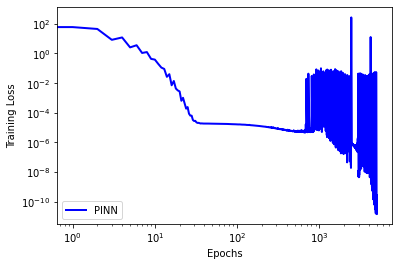

In [ ]:
n_epochs = np.arange(epochs)
# plt.loglog(n_epochs, L2_pinn, 'r-', linewidth=2,label='L2_pinn')
plt.loglog(n_epochs, loss_pinn_1, 'b-', linewidth=2,label='PINN')
# plt.loglog(n_epochs, L2_ritz, 'r--', linewidth=2,label='L2_ritz')
# plt.loglog(n_epochs, loss_ritz_2, 'g', linewidth=2,label='Deep Ritz')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

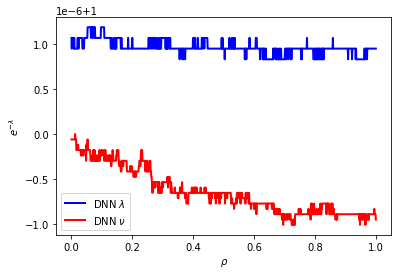

In [ ]:
plot_solution(dnn_pinn, train_data)

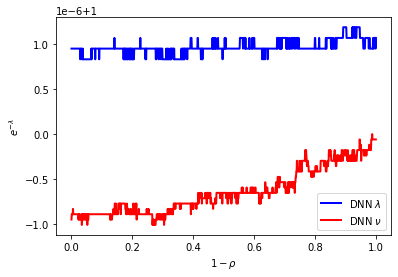

In [ ]:
plot_soln(dnn_pinn, train_data)

In [ ]:
# dnn_ritz = DNN(dim_in=1, dim_out=1, n_layers=3, n_neurons=10,activation=torch.nn.Tanh())
# loss_ritz = Residual_Deep_Ritz(dnn_ritz, train_data, f)
# optimizer_ritz = torch.optim.SGD(dnn_ritz.parameters(), lr=lr)
# loss_ritz_1 = train(dnn_ritz, loss_ritz, optimizer_ritz, batch=batch, n_epochs=epochs, n_skip=n_skip)
# loss_ritz_2 = loss_ritz_1[0]
# L2_ritz = loss_ritz_1[1]

In [1]:
# def f_new(u,xt,model=dnn_pinn,data=train_data):
#   us = model(tensor(data.xs))
#   us = us.squeeze().detach().cpu().numpy()
#   return u*(1/us-1)/xt

# # n_interior = 1000
# # train_data = UnitInterval(n_interior)

# dnn_nu = DNN(dim_in=1, dim_out=1, n_layers=3, n_neurons=10, activation=torch.nn.Tanh())

# # bdy_wt = 10.0
# loss_nu = Residual_PINN(dnn_nu, train_data, f)
# lr = 1e-3
# optimizer_nu = torch.optim.SGD(dnn_nu.parameters(), lr=lr)
# batch = 250
# epochs = 4000
# n_skip = 400

# loss_nu = train(dnn_nu, loss_nu, optimizer_nu, batch=batch, n_epochs=epochs, n_skip=n_skip)
# loss_nu_0 = loss_nu[0]
# L2_pinn = loss_nu[1]

In [ ]:
plot_solution(dnn_nu, train_data)

In [ ]:
plot_soln(dnn_nu, train_data)

In [ ]:
# plot_soln(dnn_ritz, train_data)

In [ ]:
# n_test = 111
# test_data = UnitInterval(n_test)
# loss_test = Residual(dnn, test_data, f, bdy_wt=0.0)
# test_loss = loss_test(tensor(loss_test.data.xs))
# plot_solution(dnn, test_data)
# plot_solution 